In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# A Simple Starter Code for the AJL Competition

@Cindy Deng

---


Hi! This starter code is designed to help you get familiar with basic Kaggle operations and guide you through the basic workflow of a machine learning project. 

The code outlines essential steps including data loading, preprocessing, model building, training, and generating predictions. Each section serves as a foundation, but there are many ways to enhance each step to improve your final model's accuracy. Feel free to experiment with different data augmentation techniques, model architectures, and tuning methods to optimize your final results! Some amazing tutorials are available through your AI Studio course in Canvas / in the 'Resource' section of this Kaggle competition.

Good luck and have fun!

---

## Note - About file path

You could use the cell above to print the names of the file directories and get the following directories:

```
/kaggle/input/bttai-ajl-2025/sample_submission.csv
/kaggle/input/bttai-ajl-2025/train.csv
/kaggle/input/bttai-ajl-2025/test.csv
/kaggle/input/bttai-ajl-2025/test/test/e0374ae6c1362ff183cfba28ded5421b.jpg
/kaggle/input/bttai-ajl-2025/test/test/437159c605260bdd079af230566af291.jpg
...
...
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/11271bdf2598afdd4260db3125e1f6a5.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/732819951dcf2b53d15ea7b8bb123b71.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/6dcc7a8abb5e1c6e670101f4b6231246.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/e63c3b3f0ab8905e204fe467cc7411f9.jpg
...
...
```



## 1. Import Necessary Libraries

In [2]:
# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,Dropout, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Explanation:
# - pandas and numpy: for data manipulation
# - sklearn: for splitting data and encoding labels
# - tensorflow.keras: for building and training the neural network

## 2. Load Data

Make sure to verify the file paths if you're running on a different platform.

In [3]:
# 2. Load Data
train_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/train.csv')
test_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/test.csv')

# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# Combine label and md5hash to form the correct path
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

In [4]:
# Check the first few rows to understand the structure
print(train_df.head())

                                md5hash  fitzpatrick_scale  \
0  fd06d13de341cc75ad679916c5d7e6a6.jpg                  4   
1  a4bb4e5206c4e89a303f470576fc5253.jpg                  1   
2  c94ce27e389f96bda998e7c3fa5c4a2e.jpg                  5   
3  ebcf2b50dd943c700d4e2b586fcd4425.jpg                  3   
4  c77d6c895f05fea73a8f3704307036c0.jpg                  1   

   fitzpatrick_centaur                             label nine_partition_label  \
0                    4                 prurigo-nodularis     benign-epidermal   
1                    1  basal-cell-carcinoma-morpheiform  malignant-epidermal   
2                    5                            keloid         inflammatory   
3                    3              basal-cell-carcinoma  malignant-epidermal   
4                    1                 prurigo-nodularis     benign-epidermal   

  three_partition_label            qc  ddi_scale  \
0                benign           NaN         34   
1             malignant           Na

In [5]:
#get column distributions
train_df.columns

Index(['md5hash', 'fitzpatrick_scale', 'fitzpatrick_centaur', 'label',
       'nine_partition_label', 'three_partition_label', 'qc', 'ddi_scale',
       'file_path'],
      dtype='object')

In [6]:
train_df["fitzpatrick_scale"].value_counts()

fitzpatrick_scale
 2    964
 3    562
 1    528
 4    393
 5    216
-1    108
 6     89
Name: count, dtype: int64

In [7]:
train_df["fitzpatrick_centaur"].value_counts()

fitzpatrick_centaur
 1    1000
 2     730
 3     489
 4     253
-1     161
 5     147
 6      80
Name: count, dtype: int64

In [8]:
train_df["label"].value_counts()

label
squamous-cell-carcinoma               407
basal-cell-carcinoma                  328
folliculitis                          239
acne-vulgaris                         234
melanoma                              181
eczema                                143
acne                                  128
mycosis-fungoides                     127
actinic-keratosis                     122
prurigo-nodularis                     119
kaposi-sarcoma                        109
keloid                                109
dermatomyositis                       106
superficial-spreading-melanoma-ssm     83
pyogenic-granuloma                     79
malignant-melanoma                     78
epidermal-nevus                        64
dyshidrotic-eczema                     58
dermatofibroma                         55
seborrheic-keratosis                   48
basal-cell-carcinoma-morpheiform       43
Name: count, dtype: int64

In [9]:
train_df["nine_partition_label"].value_counts()

nine_partition_label
inflammatory                    1017
malignant-epidermal              900
malignant-melanoma               342
benign-epidermal                 231
benign-dermal                    134
malignant-cutaneous-lymphoma     127
malignant-dermal                 109
Name: count, dtype: int64

In [10]:
train_df["three_partition_label"].value_counts()

three_partition_label
malignant         1478
non-neoplastic    1017
benign             365
Name: count, dtype: int64

In [11]:
train_df["qc"].value_counts()

qc
1 Diagnostic          76
5 Potentially          7
3 Wrongly labelled     4
2 Characteristic       2
4 Other                1
Name: count, dtype: int64

In [12]:
train_df["ddi_scale"].value_counts()

ddi_scale
 12    1492
 34     955
 56     305
-1      108
Name: count, dtype: int64

## 3. Data Preprocessing


This section demonstrates basic preprocessing techniques. To enhance data quality and model performance, consider incorporating more advanced preprocessing methods.

For further guidance, feel free to take a look at the [Image Preprocessing tutorial](https://colab.research.google.com/drive/1-ItNcRMbZBE6BCwPT-wD8m3YmHqwHxme?usp=sharing)  available in the 'Resources' section of this Kaggle competition.


# 3. Data Preprocessing
# Encode the labels
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Define image data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the directory paths
train_dir = '/kaggle/input/bttai-ajl-2025/train/train/'

In [13]:
image_size=(128, 128)
batch_size=32
data_dir = "/kaggle/input/bttai-ajl-2025/train/train/"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

Found 2860 files belonging to 21 classes.
Using 2288 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

Found 2860 files belonging to 21 classes.
Using 572 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['acne', 'acne-vulgaris', 'actinic-keratosis', 'basal-cell-carcinoma', 'basal-cell-carcinoma-morpheiform', 'dermatofibroma', 'dermatomyositis', 'dyshidrotic-eczema', 'eczema', 'epidermal-nevus', 'folliculitis', 'kaposi-sarcoma', 'keloid', 'malignant-melanoma', 'melanoma', 'mycosis-fungoides', 'prurigo-nodularis', 'pyogenic-granuloma', 'seborrheic-keratosis', 'squamous-cell-carcinoma', 'superficial-spreading-melanoma-ssm']


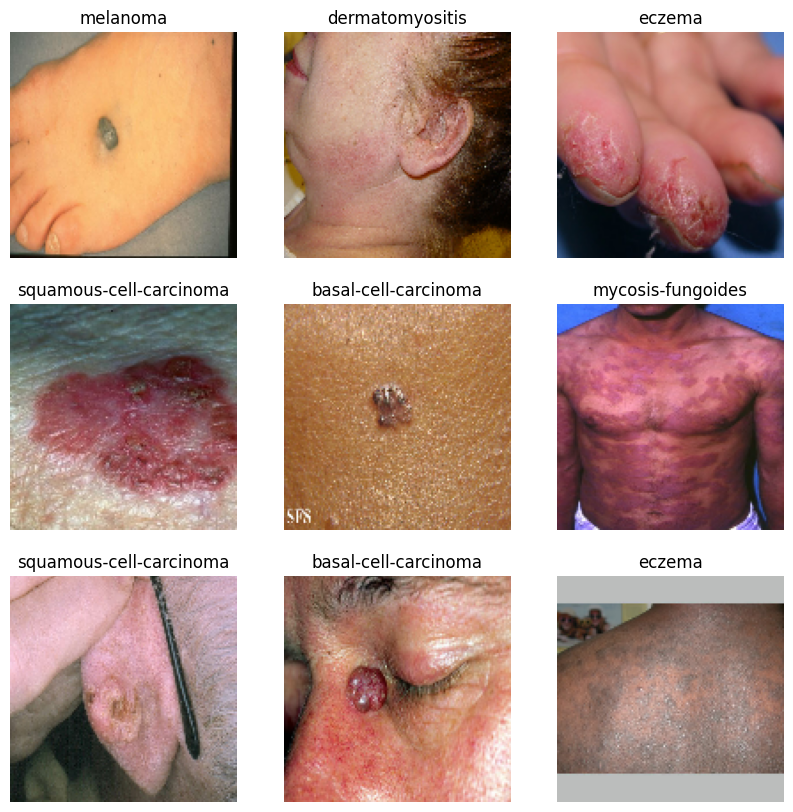

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 4. Build the model


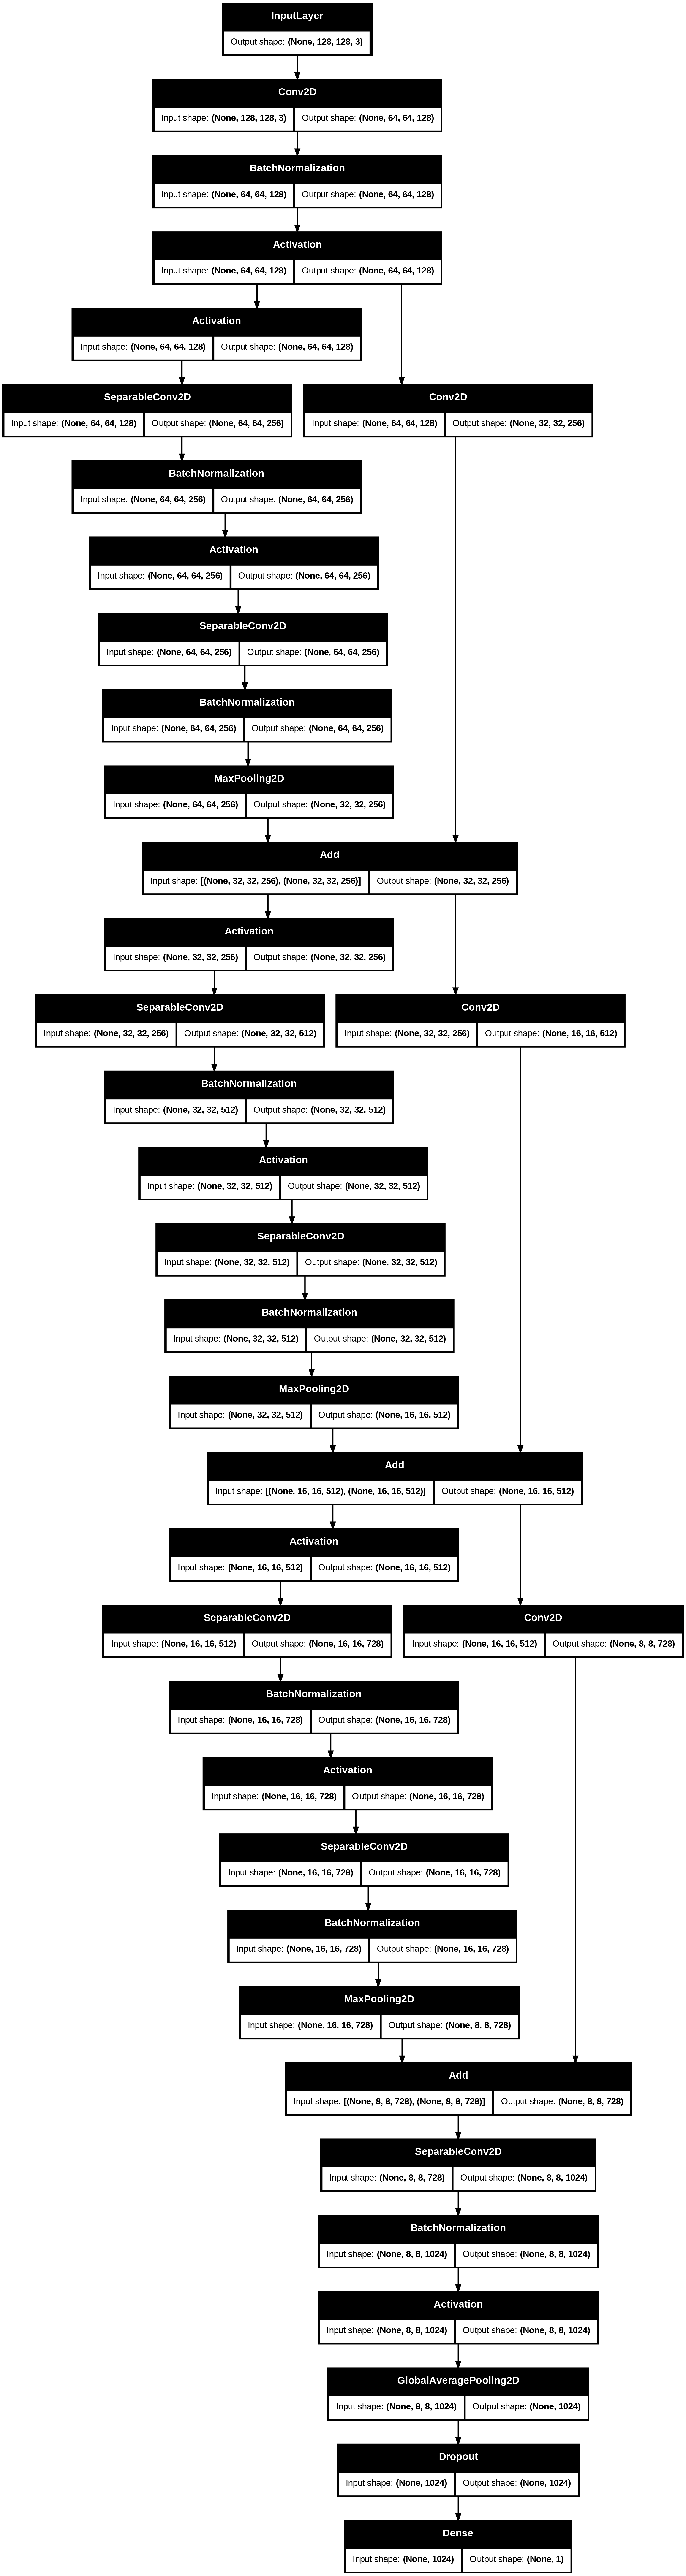

In [19]:
# TODO: You should implement the model architecture here.
# Feel free to explore different model types that best serve your purpose.
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Define the input layer with the specified shape.

    # Entry block
    #x = layers.Rescaling(1.0 / 255)(inputs)
    # Rescale pixel values from [0, 255] to [0, 1] by dividing by 255 for normalization.
    x = inputs

    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    # Apply a convolutional layer with 128 filters, a 3x3 kernel, stride of 2, and "same" padding.
    # This reduces the spatial dimensions of the input image.

    x = layers.BatchNormalization()(x)
    # Normalize the activations from the previous layer to stabilize and accelerate training.

    x = layers.Activation("relu")(x)
    # Apply ReLU (Rectified Linear Unit) activation to introduce non-linearity.

    previous_block_activation = x
    # Save the output of the entry block for residual connections.

    for size in [256, 512, 728]:
        # Loop through a series of blocks with increasing filter sizes (256, 512, 728).

        x = layers.Activation("relu")(x)
        # Apply ReLU activation to the current block's input.

        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        # Apply a depthwise separable convolution with the specified number of filters and 3x3 kernel.

        x = layers.BatchNormalization()(x)
        # Normalize the activations after the convolution.

        x = layers.Activation("relu")(x)
        # Apply ReLU activation again.

        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        # Apply another depthwise separable convolution with the same filter size.

        x = layers.BatchNormalization()(x)
        # Normalize the activations again.

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        # Apply a 3x3 max pooling layer with a stride of 2 to reduce the spatial dimensions.

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        # Apply a 1x1 convolution to the previous block's output to match dimensions for addition.

        x = layers.add([x, residual])
        # Add the residual connection to the current block's output.

        previous_block_activation = x
        # Update the residual reference for the next block.

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    # Apply a depthwise separable convolution with 1024 filters and 3x3 kernel.

    x = layers.BatchNormalization()(x)
    # Normalize the activations.

    x = layers.Activation("relu")(x)
    # Apply ReLU activation.

    x = layers.GlobalAveragePooling2D()(x)
    # Apply global average pooling to reduce each feature map to a single value.

    if num_classes == 2:
        units = 1
        # If it's a binary classification task, the output layer will have one unit.
    else:
        units = num_classes
        # For multi-class classification, the output layer will have one unit per class.

    x = layers.Dropout(0.25)(x)
    # Apply dropout with a rate of 25% to reduce overfitting.

    outputs = layers.Dense(units, activation=None)(x)
    # Define the output layer with `units` neurons. No activation is applied here (logits are returned).

    return keras.Model(inputs, outputs)
    # Create and return the Keras model.

# Create the model instance.
model = make_model(input_shape=image_size + (3,), num_classes=2)
# Call `make_model` with input shape (180, 180, 3) (for RGB images) and binary classification (2 classes).

keras.utils.plot_model(model, show_shapes=True)
# Visualize the model's architecture with layer shapes using Keras's plot_model utility.


## 5. Train the Model


In [20]:
# TODO: Train your model here.
epochs = 12

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 447s 6s/step - acc: 0.0647 - loss: -36.2034 - val_acc: 0.0804 - val_loss: -30.8918
Epoch 2/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 438s 6s/step - acc: 0.0769 - loss: -147.0829 - val_acc: 0.0787 - val_loss: -34.4311
Epoch 3/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 423s 6s/step - acc: 0.0814 - loss: -250.1952 - val_acc: 0.0647 - val_loss: -17.7544
Epoch 4/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 419s 6s/step - acc: 0.0810 - loss: -372.8236 - val_acc: 0.0594 - val_loss: -11.1605
Epoch 5/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 418s 6s/step - acc: 0.0726 - loss: -533.8027 - val_acc: 0.0822 - val_loss: -15.1315
Epoch 6/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 421s 6s/step - acc: 0.0814 - loss: -741.1505 - val_acc: 0.0804 - val_loss: -33.6709
Epoch 7/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 420s 6s/step - acc: 0.0814 - loss: -985.0811 - val_acc: 0.0804 - val_loss: -56.4742
Epoch 8/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 417s 6s/step - acc: 0.0814 - loss: -1262.9369 - val_acc: 0.0507 - val_loss: -202.6015
Epoch 9/12
72/72 ━━━━━━

In [26]:
#save model
model.save('/kaggle/working/prelim_model.keras')

## 6. Make Predictions on Test Data

In [28]:
# 6. Make Predictions on Test Data
def preprocess_test_data(test_df, directory):
    """
    Template for loading and preprocessing test images.
    """
    # TODO: create a generator for the test set here.
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='/kaggle/input/bttai-ajl-2025/test/test/',
        x_col="file_path",
        target_size=image_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False
    )
    return test_generator


In [29]:
# Load test data
test_dir = '/kaggle/input/bttai-ajl-2025/test/test/'
test_generator = preprocess_test_data(test_df, test_dir)

Found 1227 validated image filenames.


In [36]:
test_df['file_path'] = test_df['md5hash']  # Assuming test images are in a single directory

# 7. Make Predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# 8. Convert Predictions to Labels
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])
test_df['predicted_label'] = label_encoder.inverse_transform(predicted_classes)

# Save predictions
test_df[['md5hash', 'predicted_label']].to_csv(path_or_buf='/kaggle/working/submission.csv', index=False)

39/39 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step


## 7. Generate Predictions

In [24]:
# TODO
# Generate predictions based on the trained model
# Then, save the predictions into a CSV file for submission